# Classificação com Rede Neural MLP em Python
Este é o notebook com o código do quarto trabalho da disciplina de Aprendizado de Máquina.

Aluno: João Pedro Noronha de M. Souza

Link para a base de dados: https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from scipy import stats


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Coleta de Dados

Nesta etapa, carregamos o conjunto de dados Crop_recommendation.csv em um DataFrame do Pandas. Realizamos também uma inspeção inicial para entender a estrutura dos dados e a distribuição da variável alvo.

In [5]:
try:
    df = pd.read_csv('../data/Crop_recommendation.csv')
    print("Dados carregados com sucesso!")
    print("\n--- Primeiras 5 linhas do dataset ---")
    print(df.head())
    print("\n--- Informações gerais do dataset ---")
    print(df.info())
except FileNotFoundError:
    print("Erro: O arquivo 'Crop_recommendation.csv' não foi encontrado.")
    print("Por favor, baixe o dataset do Kaggle (https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset/data)")
    print("e coloque-o no mesmo diretório deste notebook.")
    raise FileNotFoundError("Dataset não encontrado. Verifique o caminho.")

# Análise inicial da variável alvo
print("\n--- Contagem de ocorrências para cada cultura (variável alvo) ---")
print(df['label'].value_counts())

Dados carregados com sucesso!

--- Primeiras 5 linhas do dataset ---
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

--- Informações gerais do dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label  

## Codificação de Variáveis Categóricas

A coluna `label` é a nossa variável alvo e contém nomes de culturas (variáveis categóricas). Para que uma rede neural possa processar esses dados, precisamos convertê-los em um formato numérico. Usaremos Label Encoding para transformar cada nome de cultura em um número inteiro único.

In [6]:
# A coluna 'label' é a nossa variável alvo e é categórica. Vamos usar Label Encoding para ela.
# Inicializa o LabelEncoder
label_encoder = LabelEncoder()

# Aplica o Label Encoding na coluna 'label' e cria uma nova coluna 'label_encoded'
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("Variável 'label' original e sua versão codificada ('label_encoded'):")
print(df[['label', 'label_encoded']].head())

# Separando as features (X) e a variável alvo (y)
# Remove a coluna original 'label' e a coluna 'label_encoded' de X
X = df.drop(['label', 'label_encoded'], axis=1)
y = df['label_encoded']

print(f"\nShape das features (X): {X.shape}")
print(f"Shape da variável alvo (y): {y.shape}")

Variável 'label' original e sua versão codificada ('label_encoded'):
  label  label_encoded
0  rice             20
1  rice             20
2  rice             20
3  rice             20
4  rice             20

Shape das features (X): (2200, 7)
Shape da variável alvo (y): (2200,)


## Remoção de Outliers

Outliers são pontos de dados que se desviam significativamente de outras observações. Eles podem afetar negativamente o desempenho do modelo. Aqui, utilizaremos o método do Intervalo Interquartil (IQR) para identificar e remover outliers de cada coluna numérica das features (X). Este método é robusto a dados não-gaussianos.

In [7]:
# # Vamos usar o método IQR (Intervalo Interquartil) para remover outliers.
# Aplicaremos a cada coluna numérica de features.
print(f"Shape das features (X) antes da remoção de outliers: {X.shape}")
print(f"Shape da variável alvo (y) antes da remoção de outliers: {y.shape}")

# Criar uma máscara para acumular as linhas que NÃO são outliers
initial_row_count = X.shape[0]
outlier_rows_mask = pd.Series([True] * initial_row_count, index=X.index)

for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Atualiza a máscara: True para dados DENTRO dos limites, False para outliers
    outlier_rows_mask = outlier_rows_mask & (X[col] >= lower_bound) & (X[col] <= upper_bound)

# Filtrar o DataFrame para remover os outliers usando a máscara acumulada
X = X[outlier_rows_mask]
y = y[outlier_rows_mask] # É crucial filtrar y também para manter a correspondência

print(f"Shape das features (X) depois da remoção de outliers: {X.shape}")
print(f"Shape da variável alvo (y) depois da remoção de outliers: {y.shape}")

# Verificação importante: assegurar que ainda restam dados
if X.shape[0] == 0:
    print("\nAVISO: Todos os dados foram removidos após a remoção de outliers.")
    print("Considere métodos de remoção de outliers menos agressivos ou a não remoção para este dataset.")
    raise ValueError("Nenhum dado restante após a remoção de outliers. Ajuste a estratégia.")

# Resetar os índices após a remoção de outliers para evitar problemas futuros de alinhamento
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print("\nÍndices de X e y resetados após remoção de outliers.")

Shape das features (X) antes da remoção de outliers: (2200, 7)
Shape da variável alvo (y) antes da remoção de outliers: (2200,)
Shape das features (X) depois da remoção de outliers: (1768, 7)
Shape da variável alvo (y) depois da remoção de outliers: (1768,)

Índices de X e y resetados após remoção de outliers.


## Escalonamento de Dados
O escalonamento de dados é fundamental para a maioria dos algoritmos de aprendizado de máquina, especialmente redes neurais. Ele padroniza as features para que tenham média 0 e desvio padrão 1, evitando que features com escalas maiores dominem o processo de treinamento e acelerando a convergência.

In [8]:
# Inicializa o StandardScaler
scaler = StandardScaler()

# Aplica a padronização nas features (X)
X_scaled = scaler.fit_transform(X)

# Converte o array numpy escalonado de volta para um DataFrame para manter os nomes das colunas
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Primeiras 5 linhas das features após o escalonamento (padronização):")
print(X_scaled_df.head())

print(f"\nMédia das primeiras colunas após escalonamento: {X_scaled_df.iloc[:, :3].mean().values}")
print(f"Desvio padrão das primeiras colunas após escalonamento: {X_scaled_df.iloc[:, :3].std().values}")

Primeiras 5 linhas das features após o escalonamento (padronização):
          N         P         K  temperature  humidity        ph  rainfall
0  0.928231 -0.126033  0.718184    -1.189446  0.545039  0.030913  2.174235
1  1.006304  0.492928  0.272680    -0.437164  0.547521  0.737749  1.808354
2  1.032328  0.227659  0.336323    -0.041045  0.483656  0.684397  2.312053
3  0.954255 -0.435513  0.463610    -0.490205  0.472392  0.717935  2.243143
4  0.902207  0.006602  0.272680    -1.082599  0.474987 -0.057939  1.812915

Média das primeiras colunas após escalonamento: [-6.43025100e-17  1.60756275e-16  1.60756275e-17]
Desvio padrão das primeiras colunas após escalonamento: [1.00028293 1.00028293 1.00028293]


## Divisão entre Treino e Teste

Para avaliar o desempenho do modelo de forma imparcial, dividimos o conjunto de dados em dois subconjuntos:

- Conjunto de Treino: Usado para treinar o modelo.
- Conjunto de Teste: Usado para avaliar o desempenho do modelo em dados não vistos durante o treinamento. Utilizaremos o método Holdout/Split com uma proporção de 80% para treinamento e 20% para teste. O parâmetro stratify=y garante que a distribuição das classes seja mantida tanto no conjunto de treino quanto no de teste, o que é crucial para problemas de classificação.

In [9]:
# random_state garante a reprodutibilidade da divisão.
# stratify=y garante que a proporção das classes seja mantida em ambos os conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape do conjunto de treino (features): {X_train.shape}")
print(f"Shape do conjunto de teste (features): {X_test.shape}")
print(f"Shape do conjunto de treino (target): {y_train.shape}")
print(f"Shape do conjunto de teste (target): {y_test.shape}")

print("\nVerificando a distribuição das classes nos conjuntos de treino e teste:")
print("Distribuição no treino:\n", y_train.value_counts(normalize=True))
print("\nDistribuição no teste:\n", y_test.value_counts(normalize=True))

Shape do conjunto de treino (features): (1414, 7)
Shape do conjunto de teste (features): (354, 7)
Shape do conjunto de treino (target): (1414,)
Shape do conjunto de teste (target): (354,)

Verificando a distribuição das classes nos conjuntos de treino e teste:
Distribuição no treino:
 label_encoded
5     0.056577
18    0.056577
19    0.056577
2     0.056577
21    0.056577
14    0.056577
10    0.056577
11    0.056577
8     0.056577
6     0.056577
9     0.056577
1     0.056577
15    0.056577
12    0.055163
4     0.048091
16    0.046676
3     0.033239
13    0.032532
17    0.030410
20    0.018388
Name: proportion, dtype: float64

Distribuição no teste:
 label_encoded
12    0.056497
11    0.056497
9     0.056497
8     0.056497
6     0.056497
15    0.056497
14    0.056497
5     0.056497
19    0.056497
1     0.056497
2     0.056497
18    0.056497
10    0.056497
21    0.056497
16    0.048023
4     0.048023
13    0.033898
17    0.031073
3     0.031073
20    0.016949
Name: proportion, dtype: flo

## Treinamento da Rede Neural MLP

Aqui, treinamos nossa Rede Neural Perceptron Multicamadas (MLP) usando sklearn.neural_network.MLPClassifier.

- `hidden_layer_sizes=(100, 50)` define a arquitetura da rede com duas camadas ocultas: a primeira com 100 neurônios e a segunda com 50 neurônios.
- `max_iter=1000` é o número máximo de épocas de treinamento.
- `activation='relu'` é a função de ativação ReLU (Rectified Linear Unit), uma escolha comum e eficaz.
- `solver='adam'` é o algoritmo de otimização Adam, conhecido por sua boa performance.
- `early_stopping=True` é uma técnica para evitar overfitting: o treinamento para se o desempenho na validação não melhorar por um certo número de épocas (`n_iter_no_change`), usando uma validation_fraction dos dados de treino como conjunto de validação interno.
- `verbose=True` imprime o progresso do treinamento, incluindo o valor da função de perda (loss).

In [10]:
# Instancia o MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Duas camadas ocultas: 100 neurônios na primeira, 50 na segunda
    max_iter=1000,                # Número máximo de iterações (épocas)
    activation='relu',            # Função de ativação ReLU
    solver='adam',                # Otimizador Adam
    random_state=42,              # Para reprodutibilidade
    early_stopping=True,          # Ativa a parada antecipada para evitar overfitting
    validation_fraction=0.1,      # 10% dos dados de treino serão usados para validação
    n_iter_no_change=10,          # Treinamento para se a validação não melhorar por 10 épocas
    verbose=True                  # Imprime o progresso do treinamento
)

print("Iniciando o treinamento da Rede Neural MLP...")
# Treina o modelo com os dados de treino
mlp.fit(X_train, y_train)
print("Treinamento da Rede Neural MLP concluído.")

Iniciando o treinamento da Rede Neural MLP...
Iteration 1, loss = 2.95056241
Validation score: 0.119718
Iteration 2, loss = 2.76444340
Validation score: 0.295775
Iteration 3, loss = 2.59298138
Validation score: 0.373239
Iteration 4, loss = 2.41431457
Validation score: 0.471831
Iteration 5, loss = 2.22694187
Validation score: 0.577465
Iteration 6, loss = 2.02580548
Validation score: 0.633803
Iteration 7, loss = 1.82322369
Validation score: 0.690141
Iteration 8, loss = 1.62024313
Validation score: 0.732394
Iteration 9, loss = 1.42589385
Validation score: 0.774648
Iteration 10, loss = 1.24253672
Validation score: 0.830986
Iteration 11, loss = 1.07323399
Validation score: 0.873239
Iteration 12, loss = 0.92621479
Validation score: 0.894366
Iteration 13, loss = 0.79648260
Validation score: 0.894366
Iteration 14, loss = 0.68772640
Validation score: 0.901408
Iteration 15, loss = 0.59691826
Validation score: 0.908451
Iteration 16, loss = 0.52177279
Validation score: 0.922535
Iteration 17, loss 

## Avaliação da Rede Neural

Após o treinamento, avaliamos o desempenho do modelo no conjunto de teste para ter uma estimativa imparcial de como ele se comportará com dados novos. Utilizaremos várias métricas:

- Acurácia: Proporção de previsões corretas.
- Matriz de Confusão: Tabela que resume as previsões corretas e incorretas para cada classe, muito útil para entender os erros do modelo.
- Precisão: Das instâncias classificadas como uma classe, quantas realmente pertenciam a essa classe.
- Recall (Sensibilidade): Das instâncias que realmente pertenciam a uma classe, quantas o modelo conseguiu identificar.
- F1-score: Média harmônica da precisão e do recall, útil para equilibrar as duas métricas, especialmente em classes desbalanceadas.
- Gráfico de Loss: Mostra como o erro (loss) da rede neural diminuiu ao longo das épocas de treinamento, indicando se o aprendizado está progredindo adequadamente.


--- Métricas de Avaliação da Rede Neural MLP ---
Acurácia: 0.9718

Matriz de Confusão:


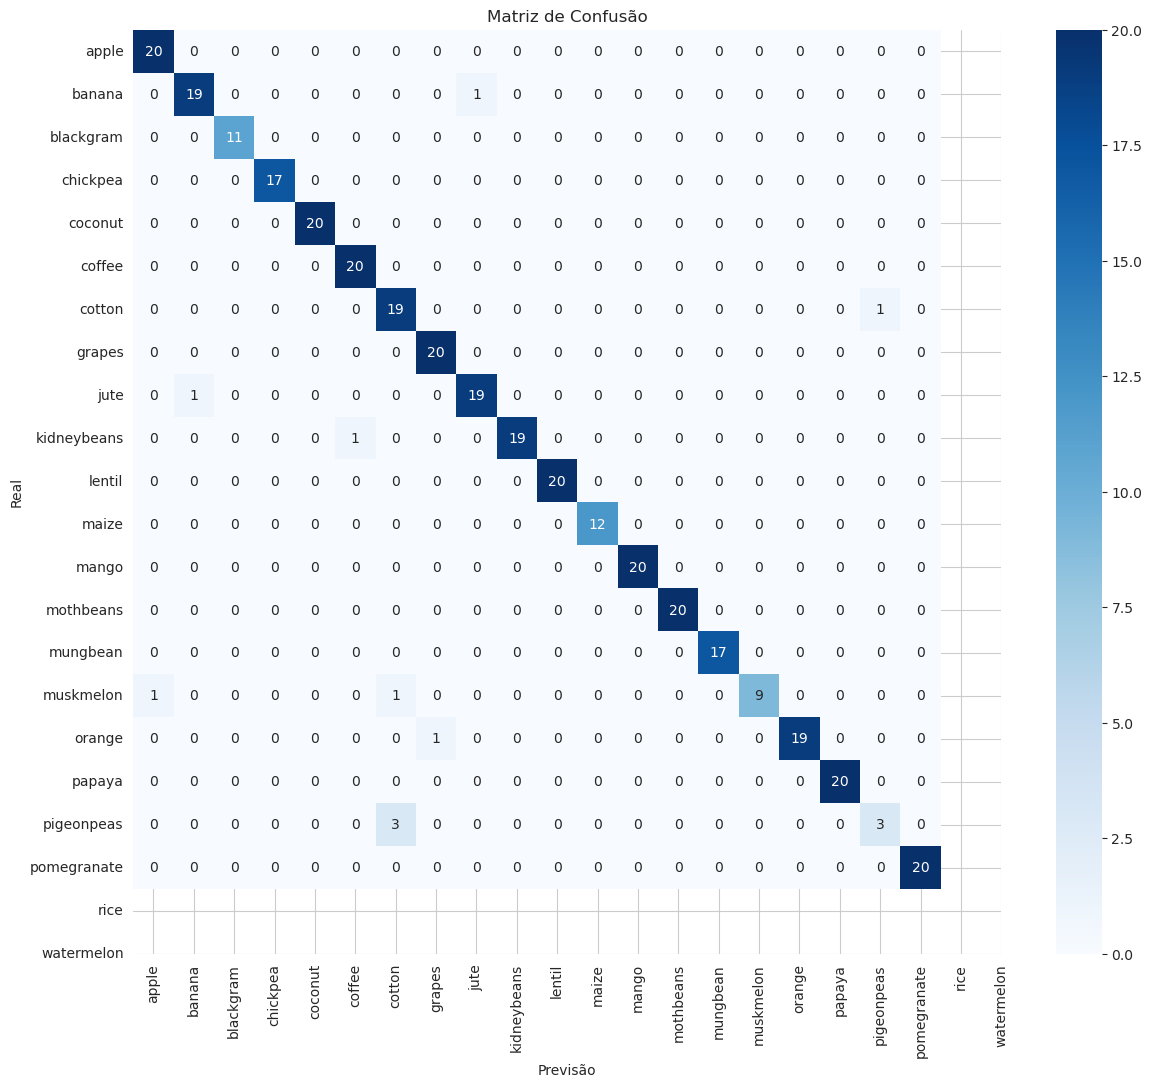

Precisão (weighted): 0.9722
Recall (weighted): 0.9718
F1-score (weighted): 0.9709


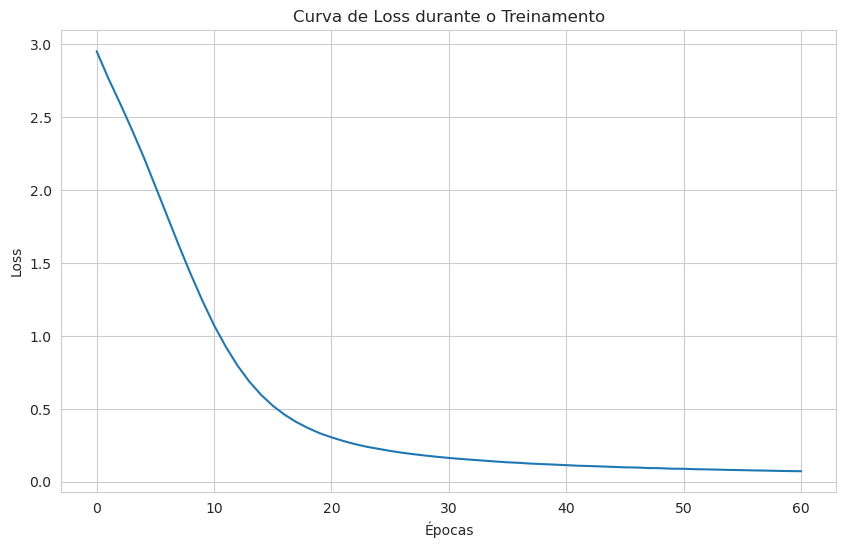


--- Alguns Exemplos de Previsões (Real vs. Previsão) ---
Amostra 1: Real: papaya, Previsão: banana
Amostra 2: Real: coconut, Previsão: coconut
Amostra 3: Real: mango, Previsão: mango
Amostra 4: Real: coffee, Previsão: coffee
Amostra 5: Real: coconut, Previsão: coconut
Amostra 6: Real: kidneybeans, Previsão: kidneybeans
Amostra 7: Real: lentil, Previsão: lentil
Amostra 8: Real: maize, Previsão: maize
Amostra 9: Real: cotton, Previsão: cotton
Amostra 10: Real: rice, Previsão: jute
Amostra 11: Real: orange, Previsão: orange
Amostra 12: Real: coconut, Previsão: coconut
Amostra 13: Real: mango, Previsão: mango
Amostra 14: Real: coffee, Previsão: coffee
Amostra 15: Real: watermelon, Previsão: watermelon


In [12]:
# Realiza previsões no conjunto de teste
y_pred = mlp.predict(X_test)

print("\n--- Métricas de Avaliação da Rede Neural MLP ---")

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
# Visualização da Matriz de Confusão
plt.figure(figsize=(14, 12)) # Aumenta o tamanho para melhor visualização de muitas classes
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, # Nomes reais das culturas para o eixo X (previsão)
            yticklabels=label_encoder.classes_) # Nomes reais das culturas para o eixo Y (real)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Precisão, Recall e F1-score
# Para problemas multiclasse, 'weighted' é uma boa opção pois considera o suporte (número de amostras) de cada classe.
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precisão (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Gráfico de loss durante o treinamento (opcional)
# A curva de loss é armazenada em mlp.loss_curve_ quando early_stopping é True
if mlp.loss_curve_ is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(mlp.loss_curve_)
    plt.title('Curva de Loss durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
else:
    print("\nCurva de Loss não disponível. Isso pode acontecer se o early_stopping não foi ativado ou a convergência foi muito rápida.")

# Imprimir alguns exemplos de previsões para visualização
print("\n--- Alguns Exemplos de Previsões (Real vs. Previsão) ---")
# Seleciona aleatoriamente algumas amostras do conjunto de teste para exibir
num_samples_to_show = 15
sample_indices = np.random.choice(len(y_test), num_samples_to_show, replace=False)

# Decodifica os valores numéricos de volta para os nomes das culturas
sample_y_test_decoded = label_encoder.inverse_transform(y_test.iloc[sample_indices])
sample_y_pred_decoded = label_encoder.inverse_transform(y_pred[sample_indices])

for i in range(num_samples_to_show):
    print(f"Amostra {i+1}: Real: {sample_y_test_decoded[i]}, Previsão: {sample_y_pred_decoded[i]}")